In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

In [6]:
wind = pd.read_pickle("MergedWindData.pkl") #this is a dataframe of all the wind angles

DEM_path = 'data\\normal_surface_bed_original.txt_cut_trim.csv'
DEM = pd.read_csv(DEM_path, index_col=False)

#I had to use the following lines instead to read the CSV in colab for some reason..
#DEM = pd.read_csv(DEM_path, header=1, index_col=False)
#DEM.drop(DEM.tail(281104).index,inplace=True)
#DEM = DEM.astype(float)

#reducing the grid to data within the (-50,+50) grid.
#this is only necessary for phyciscs informed training.
max_range =100
min_range = -max_range
wind = wind[wind['Points_0']<max_range][wind['Points_0']>min_range][wind['Points_2']<max_range][wind['Points_2']>min_range]
DEM = DEM[DEM['X']>min_range][DEM['Z']>min_range][DEM['X']<max_range][DEM['Z']<max_range]


frame_width = len(wind['Points_2'].unique())
frame_length = len(wind['Points_0'].unique())
shape=(frame_width, frame_length)

print("shape", shape)

C:\Users\James\AppData\Local\Temp\ipykernel_1876\1093735392.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind = wind[wind['Points_0']<max_range][wind['Points_0']>min_range][wind['Points_2']<max_range][wind['Points_2']>min_range]
C:\Users\James\AppData\Local\Temp\ipykernel_1876\1093735392.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind = wind[wind['Points_0']<max_range][wind['Points_0']>min_range][wind['Points_2']<max_range][wind['Points_2']>min_range]


shape (199, 199)


C:\Users\James\AppData\Local\Temp\ipykernel_1876\1093735392.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind = wind[wind['Points_0']<max_range][wind['Points_0']>min_range][wind['Points_2']<max_range][wind['Points_2']>min_range]
C:\Users\James\AppData\Local\Temp\ipykernel_1876\1093735392.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DEM = DEM[DEM['X']>min_range][DEM['Z']>min_range][DEM['X']<max_range][DEM['Z']<max_range]
C:\Users\James\AppData\Local\Temp\ipykernel_1876\1093735392.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DEM = DEM[DEM['X']>min_range][DEM['Z']>min_range][DEM['X']<max_range][DEM['Z']<max_range]
C:\Users\James\AppData\Local\Temp\ipykernel_1876\1093735392.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DEM = DEM[DEM['X']>min_range][DEM['Z']>min_range][DEM['X']<max_range][DEM['Z']<max_range]


In [95]:
size = 15
nu = 1.5E-5
gravity = -9.81
lsf = 32 # land scale factor 
wsf = 20  # wind scale factor (20 is optimal according to testing)


class PINN_NS():
    def __init__(self, lsf=1, wsf=1):
        print("\nNew object initializing")
        self.network()
        self.mse = nn.MSELoss()
        self.loss = 0
        self.loss_hist = []
        self.val_hist = []
        self.uvw_loss = 0
        self.fg_loss = 0
        self.deg = 0
        self.lsf = lsf
        self.wsf = wsf
        self.epoch_dict = defaultdict(int)

    def network(self):
        print("New network created")
        self.net = nn.Sequential(
            nn.Linear(7,size), nn.Tanh(),
            nn.Linear(size, size), nn.LeakyReLU(),#nn.Tanh(),nn.LeakyReLU(),#
            nn.Linear(size, size),nn.LeakyReLU(),# nn.Tanh(),
            nn.Linear(size, size), nn.LeakyReLU(),#nn.Tanh(),
            nn.Linear(size, size), nn.LeakyReLU(),#nn.Tanh(),
            nn.Linear(size, size), nn.LeakyReLU(),#nn.Tanh(),
            nn.Linear(size, size), nn.LeakyReLU(),#nn.Tanh(),
            nn.Linear(size, size), nn.LeakyReLU(),#nn.LeakyReLU(),#nn.Tanh(),
            nn.Linear(size, size), nn.LeakyReLU(),#nn.Tanh(),
            nn.Linear(size, 4) 
        )


        

    def function(self, x, y, h, nx, ny, nz, angle, del_graph=False):
        res = self.net(torch.hstack((x, y, h, nx, ny, nz, angle)))
        u, v, w, p = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]
               
        if self.use_physics:           
            u_x  = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
            u_y  = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

            u_h  = torch.autograd.grad(u, h, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_hh = torch.autograd.grad(u_h, h, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
            v_x  = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
            v_y  = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    
            v_h  = torch.autograd.grad(v, h, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_hh = torch.autograd.grad(v_h, h, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
            p_x  = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
            p_y  = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
            p_h  = torch.autograd.grad(p, h, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
            # compute dune hight related terms
            w_x  = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_xx = torch.autograd.grad(w_x, x, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
            w_y  = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_yy = torch.autograd.grad(w_y, y, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
            w_h  = torch.autograd.grad(w, h, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_hh = torch.autograd.grad(w_h, h, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    
            
            # u[m·s−1]              => multiply by wsf
            # u_x[m·s−1·m−1]=[s−1]  => multiply by wsf/lsf
            # p_x[kg·m−1·s−2·m−1]   => devide by lsf^2
            # nu [kg·m−1·s−1]       => devide by lsf
            # u_xx [s−1·m−1]        => multiply by wsf/lsf^2
            # gravity [m·s−2]       => devide by lsf
            #*************************************************
            #(u * u_x)             => multiply by wsf^2/lsf
            #(nu * (u_xx +...)     => multiply by wsf/lsf^3
            #m_h = [(u * w_x) + (v * w_y) + (w * w_h)]*wsf**2/lsf + p_h/lsf**2 - (nu * (w_xx + w_yy + w_hh))*wsf/lsf**3  - gravity/lsf

            
            #optionally we could now multiply LHS and RHS by lsf**3 to avoid devision which is computationally slower than multiplication.

            # add considrartion of continuty (mass conservation equation)
            c = (u_x + v_y + w_h)*wsf/lsf

            #momentume in x, y, h directions. I set u_t =0 since our model is assumed steady-state
            m_x = ((u * u_x) + (v * u_y) + (w * u_h))*wsf**2/lsf + p_x/lsf**2 - (nu * (u_xx + u_yy + u_hh))*wsf/lsf**3     
            m_y = ((u * v_x) + (v * v_y) + (w * v_h))*wsf**2/lsf + p_y/lsf**2 - (nu * (v_xx + v_yy + v_hh))*wsf/lsf**3
            m_h = ((u * w_x) + (v * w_y) + (w * w_h))*wsf**2/lsf + p_h/lsf**2 - (nu * (w_xx + w_yy + w_hh))*wsf/lsf**3  - gravity/lsf

        
        else:
            c = m_x = m_y = m_h = self.null

            
        if del_graph:
            self.optimizer.zero_grad()
        
        return u, v, w, p, c, m_x, m_y, m_h

    def closure(self):
        self.optimizer.zero_grad()
        
        u_pred, v_pred, w_pred, p_pred, c_pred, m_x_pred, m_y_pred, m_h_pred = self.function(self.x, self.y, self.h, self.nx, self.ny, self.nz, self.angle)

        if self.use_data:
            u_loss = self.mse(u_pred, self.u)
            v_loss = self.mse(v_pred, self.v)
            w_loss = self.mse(w_pred, self.w)
            self.uvw_loss = (u_loss + v_loss + w_loss)*self.wsf**2
        else:
            self.uvw_loss = 0

        if self.use_physics:
            m_x_loss = self.mse(m_x_pred, self.null)
            m_y_loss = self.mse(m_y_pred, self.null)
            m_h_loss = self.mse(m_h_pred, self.null)
            self.c_loss = self.mse(c_pred, self.null)
            self.m_loss = (m_x_loss + m_y_loss + m_x_loss)
        else:
            self.m_loss = self.c_loss = 0
        
        
        self.loss = self.uvw_loss + self.c_loss + self.m_loss

        self.validate()
        
        self.loss.backward()
        
        if not self.epoch_dict[self.deg]%10:
            print('Epoch: {:}, Loss: {:0.6f},\tValidation Loss: {:0.6f}, \tUVW Loss: {:0.6f}, \tC Loss: {:0.6f}, M Loss: {:0.6f}'.format(dict(self.epoch_dict), self.loss, self.val_loss, self.uvw_loss, self.c_loss,  self.m_loss))
        self.epoch_dict[self.deg] += 1
        self.loss_hist.append(self.loss.item())
        
        return self.loss

    def validate(self):
        u_pred, v_pred, w_pred, *_ = self.function(self.val_x, self.val_y, self.val_h, self.val_nx, self.val_ny, self.val_nz, self.val_angle)

        u_loss = self.mse(u_pred, self.val_u)
        v_loss = self.mse(v_pred, self.val_v)
        w_loss = self.mse(w_pred, self.val_w)

        self.val_loss = (u_loss + v_loss + w_loss)*self.wsf**2
        self.val_hist.append(self.val_loss.item())

    
    def load_training_data(self, X, Y, H, NX, NY, NZ, angle, U, V, W):
        print("Loading new training tensors...")
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.h = torch.tensor(H, dtype=torch.float32, requires_grad=True)
        self.nx = torch.tensor(NX, dtype=torch.float32)
        self.ny = torch.tensor(NY, dtype=torch.float32)
        self.nz = torch.tensor(NZ, dtype=torch.float32)
        self.u = torch.tensor(U, dtype=torch.float32)
        self.v = torch.tensor(V, dtype=torch.float32)
        self.w = torch.tensor(W, dtype=torch.float32)
        self.deg = np.arcsin(angle[0,0])*180/np.pi
        self.angle = torch.tensor(angle, dtype=torch.float32)
        self.null = torch.zeros((self.x.shape[0], 1))
        print("New training tensors Loaded!\n")

    def load_validaiton_data(self, X, Y, H, NX, NY, NZ, angle, U, V, W):
        print("Loading new validation tensors...")
        self.val_x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.val_y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.val_h = torch.tensor(H, dtype=torch.float32, requires_grad=True)
        self.val_nx = torch.tensor(NX, dtype=torch.float32)
        self.val_ny = torch.tensor(NY, dtype=torch.float32)
        self.val_nz = torch.tensor(NZ, dtype=torch.float32)
        self.val_u = torch.tensor(U, dtype=torch.float32)
        self.val_v = torch.tensor(V, dtype=torch.float32)
        self.val_w = torch.tensor(W, dtype=torch.float32)
        #self.val_deg = np.arcsin(angle[0,0])*180/np.pi
        self.val_angle = torch.tensor(angle, dtype=torch.float32)
        self.val_null = torch.zeros((self.val_x.shape[0], 1))
        self.val_loss =0
        print("New validation tensors Loaded!\n")
        
    def train(self, use_physics=True, use_data=True, epochs=100):
        print("Beginning Training..")
        self.use_physics = use_physics
        self.use_data = use_data
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), lr=1, max_iter=epochs, max_eval=None, tolerance_grad=1e-11,
            tolerance_change=1e-9, history_size=250, line_search_fn="strong_wolfe")#changes history size
        print("\tNew Optimizer Created.")
        #self.optimizer.zero_grad() #delete this line later
        print("Traing:\tUse Physics=", self.use_physics, "\tEpochs = ", epochs, "\tTraining Angle = ", self.deg)
        print("Note: when using mixture of training anlges only the first training angle is storeed in the Epoch dict.")
        
        self.net.train()
        self.optimizer.step(self.closure)
        print("\nTraining complete.")

    def get_lost(self):
        return self.loss_hist, self.val_hist

In [87]:
def get_preprocessed_data(w_indicies, N_points=5000, testing=False):

    angles_to_match = list(map(lambda x: 10*x-70, w_indicies)) #index 7 = 0 degrees angle
    print("angles_to_match =", angles_to_match)
    selected_wind = wind[np.isin(wind['angle'], angles_to_match)]

    #if more than one wind angle is selected we repeat the DEM dataframe to so every anlge has a corrosponding normal vector
    DEM_repeated = pd.concat([DEM]*len(w_indicies), ignore_index=True)
    
    #Extracting data from dataframe
    Points_0 = selected_wind['Points_0'].to_numpy()
    Points_1 = selected_wind['Points_1'].to_numpy()
    Points_2 = selected_wind['Points_2'].to_numpy()


    #Scaling the coords (land scale factor)
    Points_0 = (Points_0-Points_0.mean())/lsf
    Points_1 = (Points_1-Points_1.mean())/lsf
    Points_2 = (Points_2-Points_2.mean())/lsf

    #digital elevation
    dem_x = DEM_repeated['nx'].to_numpy()
    dem_y = DEM_repeated['ny'].to_numpy()
    dem_z = DEM_repeated['nz'].to_numpy()

    #Scaling the U V W data (wind scale factor)
    U_0 = np.array(selected_wind['U_0']/wsf)
    U_1 = np.array(selected_wind['U_1']/wsf)
    U_2 = np.array(selected_wind['U_2']/wsf)


    #Get Angle vector
    sin_angle = np.array(np.sin(selected_wind['angle']*np.pi/180))

    preprocessed = (Points_0, Points_1, Points_2, dem_x, dem_y, dem_z, sin_angle, U_0, U_2, U_1)
    
    return tuple([item.reshape(-1,1) for item in preprocessed])


In [61]:
PINN = PINN_NS() #create a new Model
PINN.load_training_data(*get_preprocessed_data([7])) # Load the model with data from the index=7 (0 Degree Angle)
PINN.load_validaiton_data(*get_preprocessed_data([7])) # Load the model with data from the index=7 (0 Degree Angle)
PINN.train(use_physics=False, use_data = True, epochs=30) # Set use_physics=True to include C, Mx, My, Mh in the loss function


New object initializing
New network created
angles_to_match = [0]
Loading new training tensors...
New training tensors Loaded!

angles_to_match = [0]
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
	New Optimizer Created.
Traing:	Use Physics= False 	Epochs =  30 	Training Angle =  0.0
Note: when using mixture of training anlges only the first training angle is storeed in the Epoch dict.
Epoch: {0.0: 0}, Loss: 3.543102,	Validation Loss: 3.543102, 	UVW Loss: 3.543102, 	C Loss: 0.000000, M Loss: 0.000000
wind scale factor =  1
Epoch: {0.0: 10}, Loss: 1.402560,	Validation Loss: 1.402560, 	UVW Loss: 1.402560, 	C Loss: 0.000000, M Loss: 0.000000
wind scale factor =  1
Epoch: {0.0: 20}, Loss: 1.402435,	Validation Loss: 1.402435, 	UVW Loss: 1.402435, 	C Loss: 0.000000, M Loss: 0.000000
wind scale factor =  1
Epoch: {0.0: 30}, Loss: 1.400246,	Validation Loss: 1.400246, 	UVW Loss: 1.400246, 	C Loss: 0.000000, M Loss: 0.000000
wind scale factor =  1

Traini

In [103]:
models = []
for i in range(14,21,2):
    wsf = i
    print("i =", i)

    PINN_data = PINN_NS(wsf = i) #create a new Model
    PINN_data.load_training_data(*get_preprocessed_data([7])) # Load the model with data from the index=7 (0 Degree Angle)
    PINN_data.load_validaiton_data(*get_preprocessed_data([7])) # Load the model with data from the index=7 (0 Degree Angle)
    PINN_data.train(use_physics=False, epochs=600) # Set use_physics=True to include C, Mx, My, Mh in the loss function
    models.append(PINN_data)

i = 14

New object initializing
New network created
angles_to_match = [0]
Loading new training tensors...
New training tensors Loaded!

angles_to_match = [0]
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
	New Optimizer Created.
Traing:	Use Physics= False 	Epochs =  600 	Training Angle =  0.0
Note: when using mixture of training anlges only the first training angle is storeed in the Epoch dict.
Epoch: {0.0: 0}, Loss: 299.199493,	Validation Loss: 299.199493, 	UVW Loss: 299.199493, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 10}, Loss: 50.258675,	Validation Loss: 50.258675, 	UVW Loss: 50.258675, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 20}, Loss: 49.747154,	Validation Loss: 49.747154, 	UVW Loss: 49.747154, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 30}, Loss: 38.614586,	Validation Loss: 38.614586, 	UVW Loss: 38.614586, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 40}, Loss: 35.178116,	Validation Loss: 35.178116, 	UVW Loss: 35

In [105]:
models[0].train(use_physics=False, epochs=1500)
models[3].train(use_physics=False, epochs=1500)


Beginning Training..
	New Optimizer Created.
Traing:	Use Physics= False 	Epochs =  1500 	Training Angle =  0.0
Note: when using mixture of training anlges only the first training angle is storeed in the Epoch dict.
Epoch: {0.0: 630}, Loss: 11.925797,	Validation Loss: 11.925797, 	UVW Loss: 11.925797, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 640}, Loss: 11.897821,	Validation Loss: 11.897821, 	UVW Loss: 11.897821, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 650}, Loss: 11.851865,	Validation Loss: 11.851865, 	UVW Loss: 11.851865, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 660}, Loss: 11.808879,	Validation Loss: 11.808879, 	UVW Loss: 11.808879, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 670}, Loss: 11.753002,	Validation Loss: 11.753002, 	UVW Loss: 11.753002, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 680}, Loss: 11.706236,	Validation Loss: 11.706236, 	UVW Loss: 11.706236, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 690}, Loss: 11.661886,	Validation Loss: 

In [98]:
styl_list=['-','--','-.',':']
clrs_list=['k','b','g','r']

In [111]:
models[0].u

tensor([[1.1899],
        [1.1969],
        [1.2076],
        ...,
        [1.2808],
        [1.3105],
        [1.3170]], device='cuda:0')

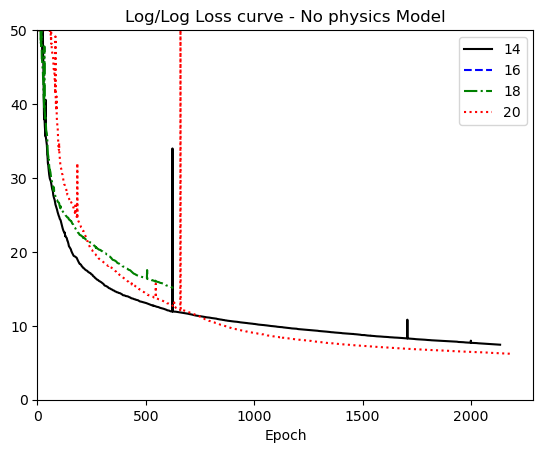

In [106]:
for i,PINN in enumerate(models):
  test_hist, val_hist = PINN.get_lost()
  wsf = PINN.wsf
  test_hist= [min(value, 50) for value in test_hist]
  #val_hist = [min(value, test_hist[0]*1.2) for value in val_hist]
  clrr=clrs_list[i % 4]
  styl=styl_list[i % 4]
  plt.plot(test_hist, label=wsf,color=clrr,ls=styl)
#plt.plot(val_hist,color=clrr,ls=styl, label='Validation Loss')
plt.xlim(0,)
plt.ylim(0.0,50)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Epoch')
#plt.ylabel('Loss (Log Curve)')
plt.title('Log/Log Loss curve - No physics Model')
plt.legend(loc='upper right')
#plt.savefig("LogLoss Curve with Validation(0 deg), No physics Model(-10+10deg).png")
plt.show()

In [ ]:
#results: 18 performs best
#results: 14 performs best..going lower again

#interestingly 14 was beating 20 but 20 had a steeper gradient at the end.. running for more epochs revealed 20 was actually better

In [27]:
#torch.save(PINN, './models/model.pt')
#PINN = torch.load('./models/model.pt')

In [29]:
#get the preprocessed data and true U values
*preprocessed_data,  U_0, U_1, U_2 = get_preprocessed_data([7])

#convert preprocessed data to tensors of the correct shape
preprocessed_data = tuple([torch.tensor(item, dtype=torch.float32, requires_grad=True) for item in preprocessed_data])

NN_out = PINN.net(torch.hstack((preprocessed_data)))
u_pred = NN_out[:, 0].data.cpu().numpy().reshape(shape)
v_pred = NN_out[:, 1].data.cpu().numpy().reshape(shape)
w_pred = NN_out[:, 2].data.cpu().numpy().reshape(shape)

angles_to_match = [0]


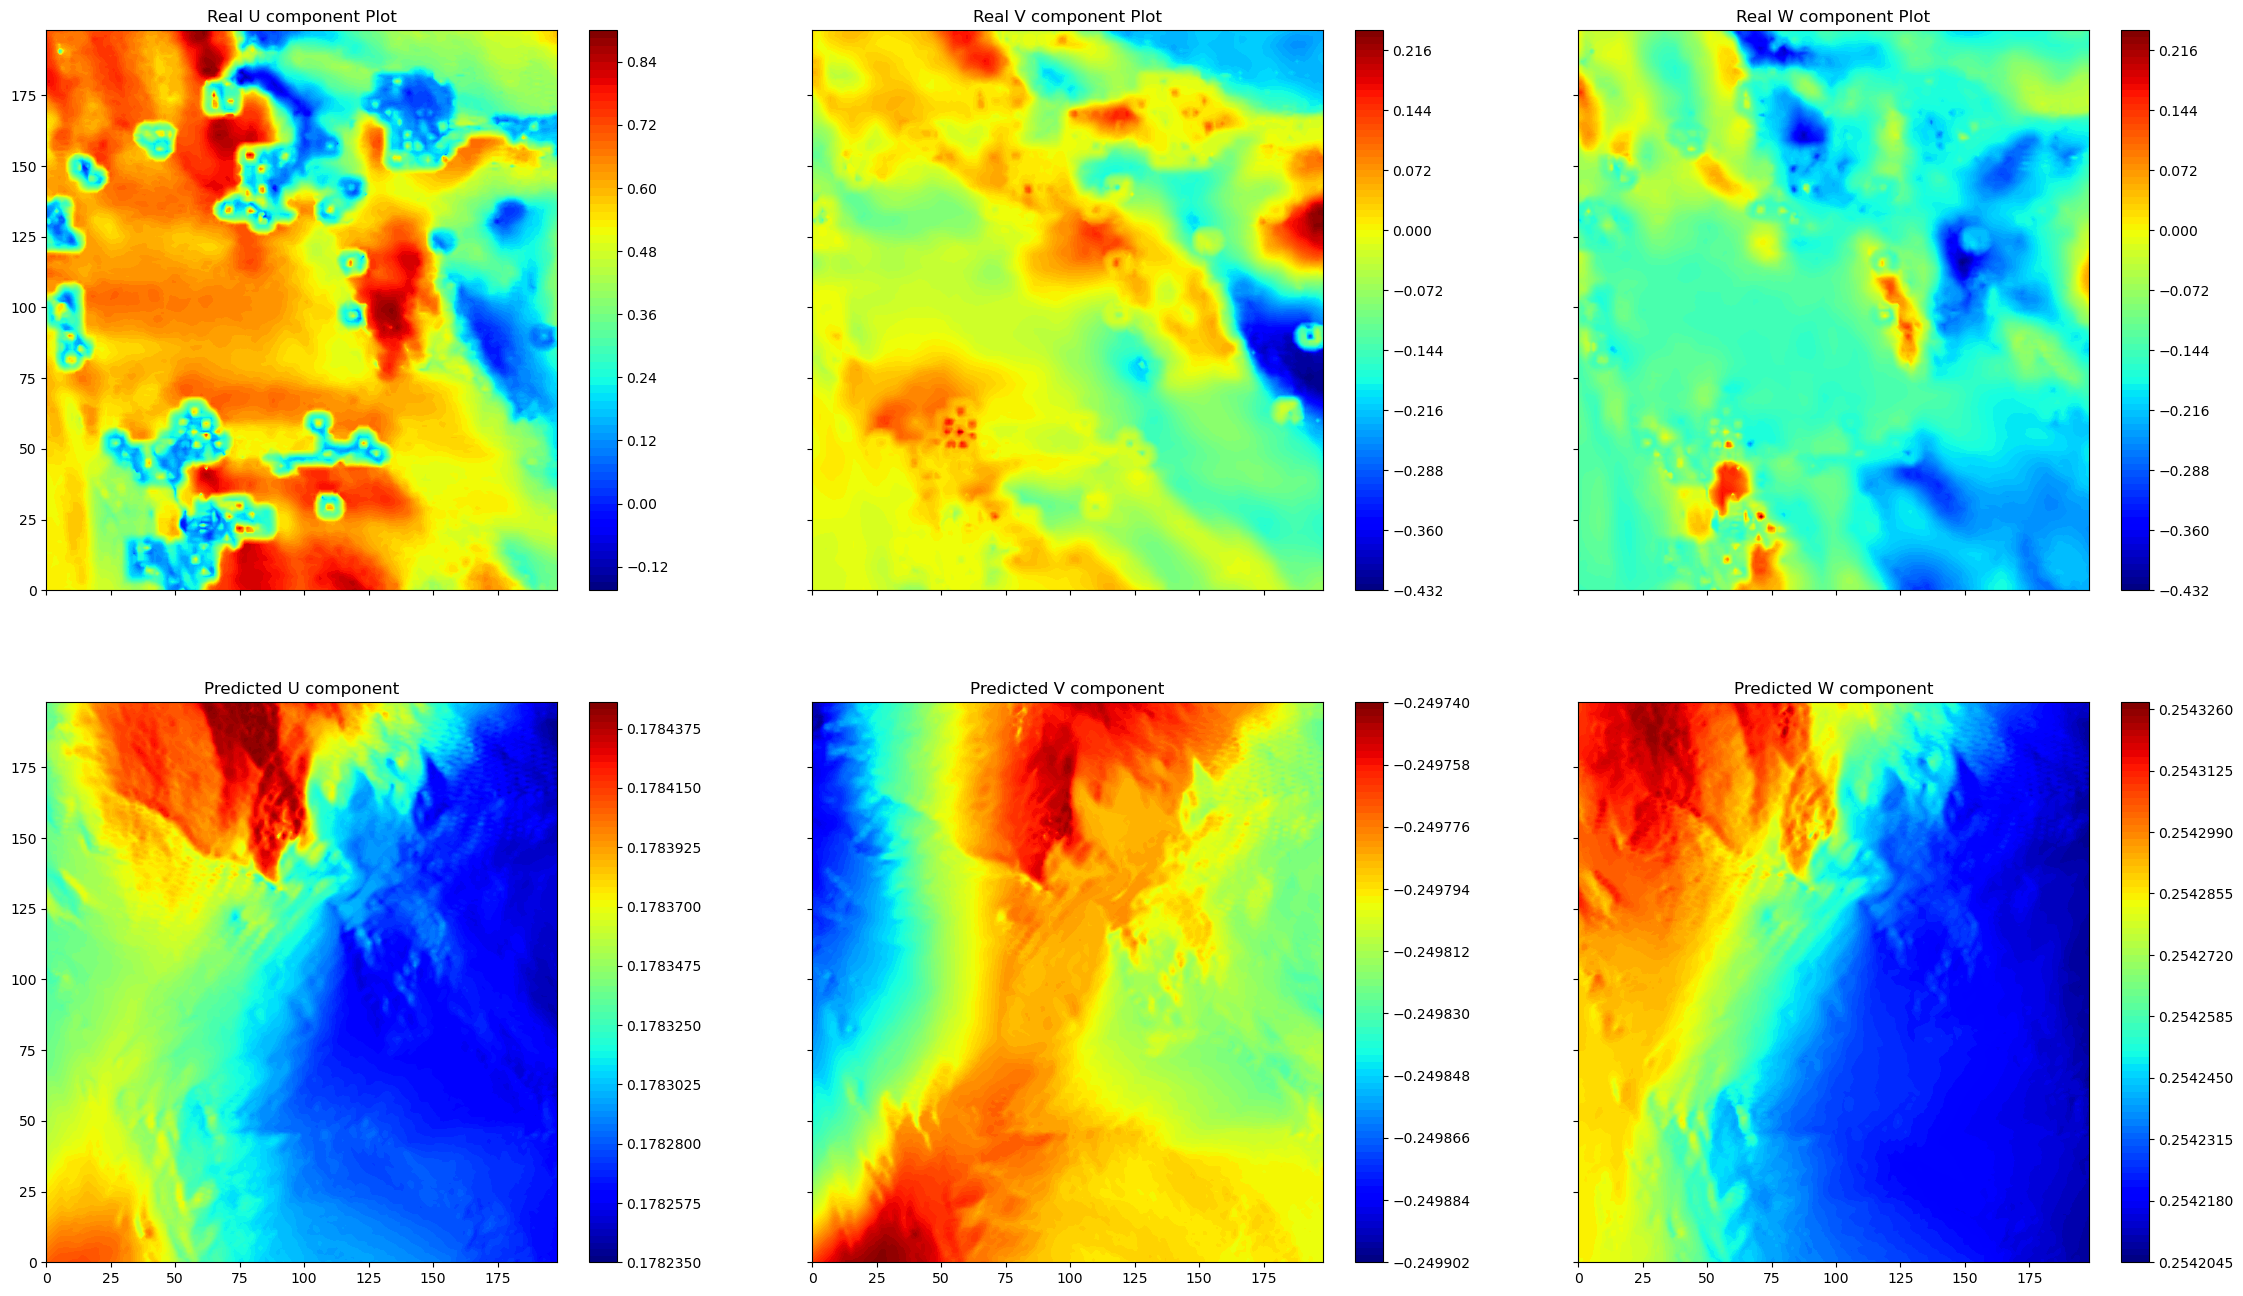

In [30]:
fig, axs = plt.subplots(2,3,  figsize=(28,16), sharex=True, sharey=True)

## Truth Data
p1 = axs[0,0].contourf(U_0.reshape(shape), levels=100, cmap='jet')
fig.colorbar(p1, ax=axs[0,0])
axs[0,0].title.set_text('Real U component Plot')
    
    
p2 = axs[0,1].contourf(U_1.reshape(shape), levels=100, cmap='jet')
fig.colorbar(p2, ax=axs[0,1])
axs[0,1].title.set_text('Real V component Plot')

p3 = axs[0,2].contourf(U_2.reshape(shape), levels=100, cmap='jet')
fig.colorbar(p2, ax=axs[0,2])
axs[0,2].title.set_text('Real W component Plot')


## Prediction Data
p4 = axs[1,0].contourf(u_pred, levels=100, cmap='jet')
fig.colorbar(p4, ax=axs[1,0])
axs[1,0].title.set_text('Predicted U component')
    
    
p5 = axs[1,1].contourf(v_pred, levels=100, cmap='jet')
fig.colorbar(p5, ax=axs[1,1])
axs[1,1].title.set_text('Predicted V component')

p6 = axs[1,2].contourf(w_pred, levels=100, cmap='jet')
fig.colorbar(p6, ax=axs[1,2])
axs[1,2].title.set_text('Predicted W component')

#plt.savefig("fig_name.png", dpi=300) 